In [2]:
import anndata
import umap
import xgboost
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import re
import joblib
import plotly
regex = re.compile(r"perturbation_experiment_([^_]+)_level")

# base definition and original adata:
if not "adata" in locals():
    levels = ["0", "0.5", "1.0"]
    data_dir = "/data/gene_perturbation_colon_epithelial_scGPT_with_binning_1"
    file_pattern = data_dir + "/perturbation_experiment_{gene}_level_{level}"
    base_fname = file_pattern.format(gene = "JUND", level = "1.0")
    base_embeddings = np.load(f"{base_fname}.embeddings.npy")
    adata = anndata.read_h5ad(f"{base_fname}.h5ad")
    base_df = adata.obs[["tissue", "cell_type", 'sex', 'development_stage',"disease"]].copy()
    colon_model = joblib.load("colon_crohn_model_xgboost.joblib")
    colon_index = adata.obs.reset_index().query("tissue == 'colon'").index
    colon_embeddings = base_embeddings[colon_index]

data_dir = "/data/perturbation_bining_colon_epothelial_take_7"
data_dir2 = "/data/colon_epithelial_cellxgene_perturbation_4/perturbations"

genes = list(set([regex.search(f.name).group(1) for f in list(Path(data_dir).glob("*.npz"))]))
genes2 = list(set([regex.search(f.name).group(1) for f in list(Path(data_dir2).glob("*.npz"))]))

genes = list(set(genes + genes2))
len(genes)

31

In [3]:
# gene expression data
if not "gene_epression_adata" in globals():
    gene_epression_adata = anndata.read_h5ad(
        "/data/colon_epithelial_cellxgene/ae802158-1a7e-43e0-9c23-cdc688ce3481.h5ad"
    )
genes_index = (
    gene_epression_adata.var.reset_index()
    .query("feature_name in @genes")[["feature_name"]]
    .reset_index()
)
df = pd.DataFrame(
    gene_epression_adata.X[:, genes_index["index"].tolist()].todense(),
    columns=genes_index["feature_name"].tolist(),
    index = gene_epression_adata.obs.reset_index().set_index(["cell_id", "tissue", "cell_type", "development_stage", "disease"]).index
).query("tissue == 'colon'") # !!!!
df.head()

,,,,,IFI6,TSPAN1,IL23R,PTPN22,S100A9,IL10,CTNNB1,SLC22A5,IRGM,HSP90AB1,...,ZG16,NOD2,MT1G,KRT19,STAT3,PTPN2,CD320,JUND,CEACAM5,IL12B
cell_id,tissue,cell_type,development_stage,disease,,,,,,,,,,,,,,,,,,,,,
H197396_N1-GCTTGAAGTCATGCCG,colon,enterocyte,eighth decade human stage,normal,0.0,2.80,0.0,0.00,0.0,0.0,1.58,0.0,0.0,3.94,...,0.00,0.0,4.76,4.14,1.58,0.0,1.58,4.14,0.00,0.0
H197396_N1-AGGGAGTCACCTTGTC,colon,enterocyte,eighth decade human stage,normal,0.0,1.72,0.0,0.00,0.0,0.0,3.17,0.0,0.0,4.10,...,0.00,0.0,4.37,4.10,1.72,0.0,2.32,3.50,1.72,0.0
H197396_N1-CATATTCAGGGAGTAA,colon,enterocyte,eighth decade human stage,normal,0.0,4.02,0.0,0.00,0.0,0.0,1.79,0.0,0.0,3.25,...,2.77,0.0,3.58,5.56,2.77,0.0,2.77,4.26,0.00,0.0
H197396_N1-CGCTTCAAGGCTACGA,colon,enterocyte,eighth decade human stage,normal,1.8,1.80,0.0,0.00,0.0,0.0,2.41,0.0,0.0,3.84,...,1.80,0.0,5.06,3.72,0.00,1.8,1.80,4.27,2.78,0.0
H197396_N1-CGGAGTCGTGAGTGAC,colon,goblet cell,eighth decade human stage,normal,0.0,2.46,0.0,1.85,0.0,0.0,2.84,0.0,0.0,4.00,...,0.00,0.0,5.49,4.68,2.46,0.0,0.00,4.52,2.46,0.0


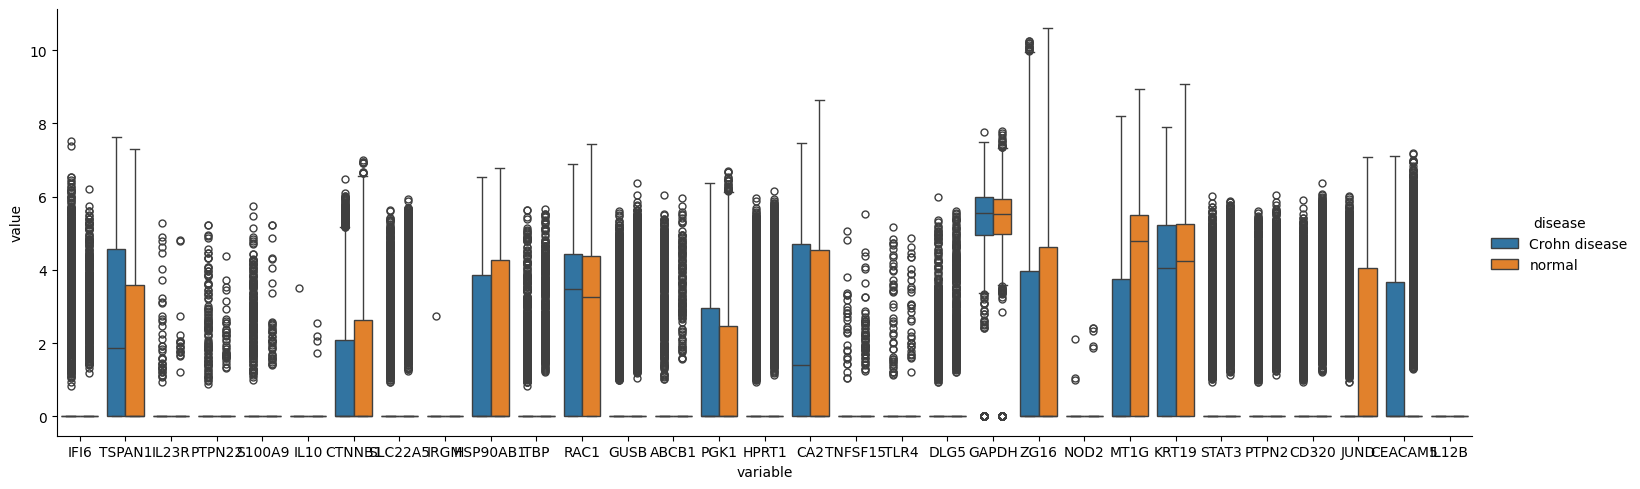

In [4]:
melted = df.reset_index().drop(columns=["cell_id"]).melt(["tissue", "cell_type", "development_stage", "disease"])
melted
sns.catplot(data=melted, x="variable", y="value", hue="disease",kind="box", aspect=3)

# Most of the genes we alter exhibit low expression levels across the dataset (close to zero), with only a few showing a distinct difference between Crohn's disease and normal samples.

In [5]:
# what is the fraction of non-zero expression of each genes?
non_zero_fraction = df.apply(lambda x: (x > 0).sum() / len(x)).reset_index()
non_zero_fraction["total_non_zeo"] = df.apply(lambda x: (x > 0).sum()).values
non_zero_fraction

,index,0,total_non_zeo
0,IFI6,0.040385,1121
1,TSPAN1,0.416637,11565
2,IL23R,0.001945,54
3,PTPN22,0.004863,135
4,S100A9,0.008394,233
5,IL10,0.000180,5
6,CTNNB1,0.292636,8123
7,SLC22A5,0.054147,1503
8,IRGM,0.000036,1
9,HSP90AB1,0.480906,13349


In [6]:
# what si the difference between the disease states if each gene?
disease_diff = df.reset_index().groupby("disease")[df.columns.tolist()].mean().T
disease_diff["diff"] = abs((disease_diff["Crohn disease"] - disease_diff["normal"])/disease_diff["normal"]) * 100
disease_diff.sort_values("diff", ascending=False)

/tmp/ipykernel_18170/4019688527.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_diff = df.reset_index().groupby("disease")[df.columns.tolist()].mean().T


disease,Crohn disease,normal,diff
IRGM,0.000251,0.000000,inf
S100A9,0.048941,0.005968,720.107483
PTPN22,0.023562,0.004825,388.332855
ABCB1,0.114785,0.027164,322.558044
IL23R,0.007863,0.002270,246.294571
IFI6,0.239976,0.073249,227.616379
CEACAM5,1.656227,0.694512,138.473267
TLR4,0.011411,0.005511,107.067551
HPRT1,0.488506,0.272367,79.355507
JUND,0.620376,1.741529,64.377510


In [7]:
relevant_genes = non_zero_fraction.query("total_non_zeo > 1000")["index"].tolist()
len(relevant_genes)

19

In [8]:
# now check the effect of the perturbation only in cells that have the gene expressed in the first place !!!
df["disease_probability"] = colon_model.predict_proba(colon_embeddings)[:, 0]
levels = {0:"KO", 5.0:"OE", 1: "WT"}
def calculate_disease_proba_of_gene(params):
    gene, level = params
    df_ = df[[gene, "disease_probability"]].rename(columns = {gene: "expression"}).copy()
    df_["gene"] = gene
    df_["level"] = levels[level]
    if level == 1:
        df_["pert_probability"] = df_["disease_probability"]
        df_[f"probaility_change"] = 0
        return df_
    path = data_dir + f"/perturbation_experiment_{gene}_level_{level}.embeddings.npz"
    if not Path(path).exists():
        path = data_dir2 + f"/perturbation_experiment_{gene}_level_{level}.embeddings.npz"
    embeddings = np.load(path)["emb"][colon_index]    
    df_[f'pert_probability'] = colon_model.predict_proba(embeddings)[:, 0]
    df_[f"probaility_change"] = df_["pert_probability"] - df_[f'disease_probability']
    return df_

params = [(gene, level) for gene in relevant_genes for level in [0, 5.0, 1]]
# dfs = process_map(calculate_disease_proba_of_gene, params, max_workers=4, tqdm_class=tqdm)
if not "dfs" in globals():
    dfs = []
    for param in tqdm(params):
        dfs.append(calculate_disease_proba_of_gene(param))
    dfs = pd.concat(dfs)
dfs

100%|██████████| 57/57 [00:54<00:00,  1.04it/s]


,,,,,expression,disease_probability,gene,level,pert_probability,probaility_change
cell_id,tissue,cell_type,development_stage,disease,,,,,,
H197396_N1-GCTTGAAGTCATGCCG,colon,enterocyte,eighth decade human stage,normal,0.0,0.000008,IFI6,KO,1.418591e-05,0.000006
H197396_N1-AGGGAGTCACCTTGTC,colon,enterocyte,eighth decade human stage,normal,0.0,0.000475,IFI6,KO,2.664924e-04,-0.000209
H197396_N1-CATATTCAGGGAGTAA,colon,enterocyte,eighth decade human stage,normal,0.0,0.002102,IFI6,KO,7.052422e-04,-0.001396
H197396_N1-CGCTTCAAGGCTACGA,colon,enterocyte,eighth decade human stage,normal,1.8,0.000214,IFI6,KO,3.337860e-06,-0.000211
H197396_N1-CGGAGTCGTGAGTGAC,colon,goblet cell,eighth decade human stage,normal,0.0,0.000002,IFI6,KO,4.768372e-07,-0.000002
...,...,...,...,...,...,...,...,...,...,...
N114902_N-CTGCGGACACAGGCCT,colon,enterocyte,fourth decade human stage,Crohn disease,0.0,0.990118,CEACAM5,WT,9.901178e-01,0.000000
N114902_N-TTGCGTCTCAAAGACA,colon,enterocyte,fourth decade human stage,Crohn disease,0.0,0.978952,CEACAM5,WT,9.789524e-01,0.000000
N114902_N-TGCGCAGCAACAACCT,colon,enterocyte,fourth decade human stage,Crohn disease,0.0,0.990911,CEACAM5,WT,9.909105e-01,0.000000


Text(0.5, 1.0, 'Impact of Gene Perturbation on The Predicted Disease Probability\n(Only in Cells with Expression > 0)')

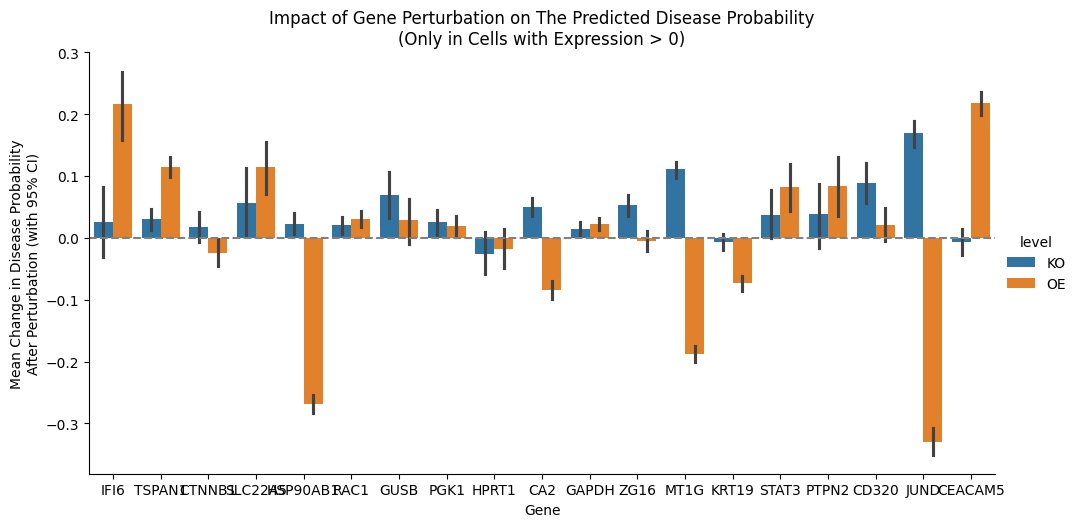

In [9]:
# now only consider genes that the expression > 0 in the analysis:
data = dfs.query("expression > 0").query("abs(probaility_change) > 0.05")
sns.catplot(data=data, x="gene", y="probaility_change", hue="level", kind="bar", aspect=2)
# add grey horizontal line at 0
plt.axhline(0, color='grey', linestyle='--')
plt.ylabel("Mean Change in Disease Probability\nAfter Perturbation (with 95% CI)")
plt.xlabel("Gene")
plt.title("Impact of Gene Perturbation on The Predicted Disease Probability\n(Only in Cells with Expression > 0)")

description: "The chart provides insights into how specific gene perturbations can significantly alter the predicted probability of a disease. It highlights that overexpression or knockout of certain genes can either exacerbate or reduce disease risk, offering potential targets for therapeutic intervention."

In [10]:
from scipy.stats import ttest_1samp
import itertools

# significance analysis:
grouped = data.groupby(['gene', 'level'])

# Function to perform t-test
def t_test(group):
    _, p_value = ttest_1samp(group['probaility_change'], 0)
    return p_value
    

results = grouped.apply(t_test).reset_index()
results.columns = ['gene', 'level', 'p_value']

# Correct for multiple testing
results['significance'] = results['p_value'].apply(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'ns')
results

stats = grouped["probaility_change"].agg(["mean", "std", "count"]).reset_index().assign(stderr = lambda x: x["std"] / np.sqrt(x["count"]))
results = results.merge(stats, how='left', on=["gene", "level"])
results

/tmp/ipykernel_18170/2607660061.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = grouped.apply(t_test).reset_index()


,gene,level,p_value,significance,mean,std,count,stderr
0,CA2,KO,6.186354e-11,***,0.049884,0.396766,2727,0.007598
1,CA2,OE,3.748635e-29,***,-0.084388,0.395157,2817,0.007445
2,CD320,KO,3.580918e-08,***,0.089154,0.390800,599,0.015968
3,CD320,OE,1.390803e-01,ns,0.020684,0.399535,818,0.013969
4,CEACAM5,KO,5.083972e-01,ns,-0.007309,0.385107,1215,0.011048
5,CEACAM5,OE,7.136836e-85,***,0.217827,0.382596,1358,0.010382
6,CTNNB1,KO,1.433572e-01,ns,0.017790,0.373787,947,0.012146
7,CTNNB1,OE,2.865019e-02,*,-0.024196,0.393445,1269,0.011045
8,GAPDH,KO,8.036711e-03,**,0.014677,0.396833,5140,0.005535
9,GAPDH,OE,2.453690e-05,***,0.022057,0.416949,6370,0.005224


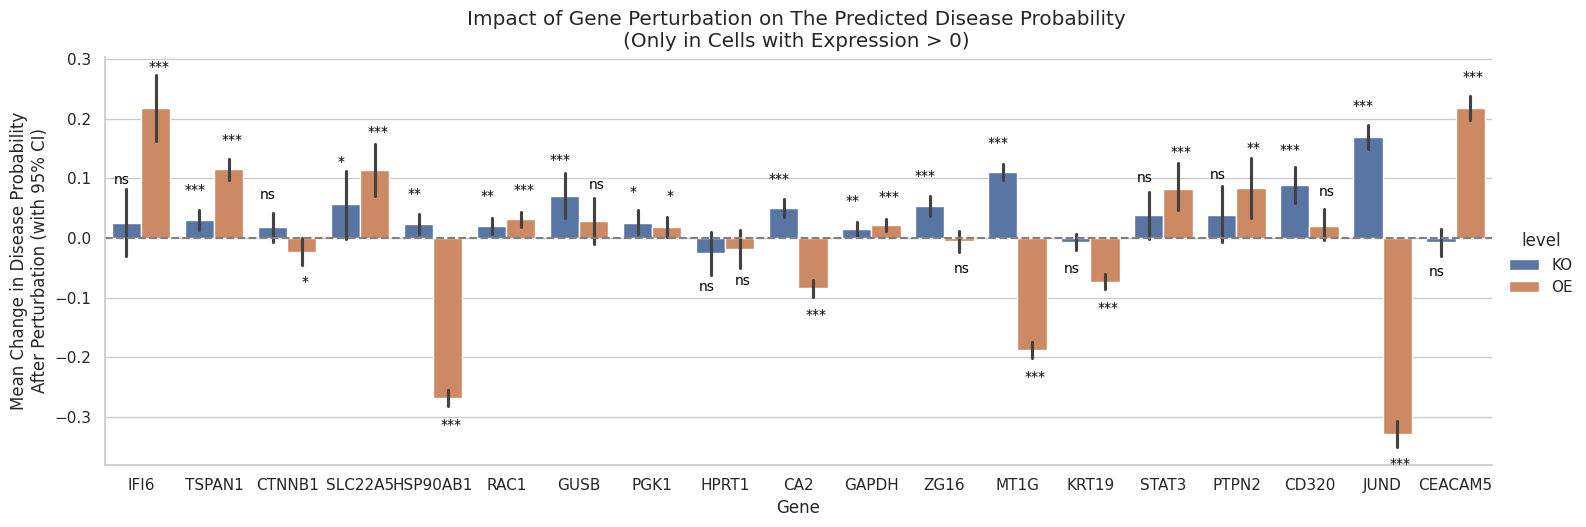

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Plot the data
sns.set(style='whitegrid')
g = sns.catplot(data=data, x="gene", y="probaility_change", hue="level", kind="bar", aspect=3)
g.set_axis_labels("Gene", "Mean Change in Disease Probability\nAfter Perturbation (with 95% CI)")
g.fig.suptitle("Impact of Gene Perturbation on The Predicted Disease Probability\n(Only in Cells with Expression > 0)", y=1.05)
plt.axhline(0, color='grey', linestyle='--')

xticks = [t.get_text() for t in g.ax.get_xticklabels()]
legend_labels = ["KO","OE"]
for idx,(gene, level) in enumerate(itertools.product(xticks, legend_labels)):
    row = results.query(f"gene == '{gene}' and level == '{level}'")
    significance = row['significance'].values[0]
    mean = row['mean'].values[0]
    stderr = row['stderr'].values[0]
    bar_x = idx*0.5 - 0.26
    y_pos = mean + stderr + 0.03
    if mean < 0:
        y_pos = mean - stderr - 0.05
    plt.text(bar_x, y_pos, significance, ha='center', va='bottom', fontsize=10, color='black')




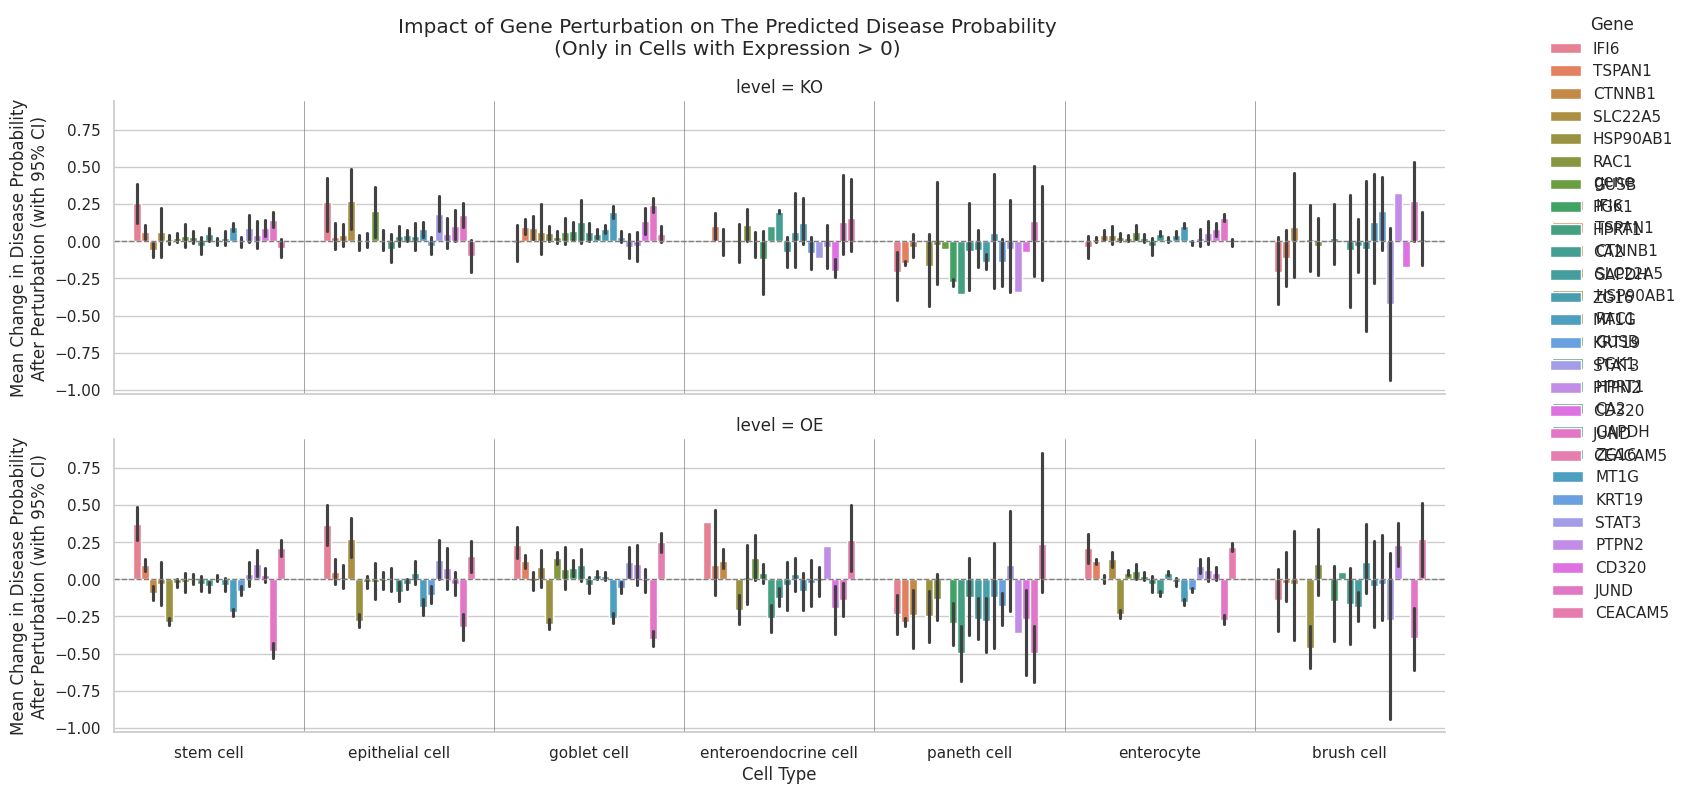

In [12]:
g = sns.catplot(data=data, x="cell_type", y="probaility_change", row="level", hue="gene", kind="bar", aspect=3, height=4)
g.fig.suptitle("Impact of Gene Perturbation on The Predicted Disease Probability\n(Only in Cells with Expression > 0)")
g.set_axis_labels("Cell Type","Mean Change in Disease Probability\nAfter Perturbation (with 95% CI)")
g.add_legend(title="Gene", bbox_to_anchor=(1.05, 1), loc='upper left')
for ax in g.axes.flat:
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)
    cell_type_positions = range(1, data.reset_index()['cell_type'].nunique())
    for pos in cell_type_positions:
        ax.axvline(pos-0.5, linestyle='-', color='gray', linewidth=0.5)
g.fig.tight_layout()

# create and heatmap of the effect of genes on the disease predictions, with signicant level for different cell types


In [13]:
group_cols = ["gene", "level", "cell_type"]
grouped = data.groupby(group_cols, observed=True)

# Function to perform t-test
def t_test(group):
    _, p_value = ttest_1samp(group['probaility_change'], 0)
    return p_value

results = grouped.apply(t_test, include_groups=False).reset_index()
results.columns = [*group_cols, 'p_value']

# Correct for multiple testing
results['significance'] = results['p_value'].apply(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'ns')
results

stats = grouped["probaility_change"].agg(["mean", "std", "count"]).reset_index().assign(stderr = lambda x: x["std"] / np.sqrt(x["count"]))
results = results.merge(stats, how='left', on=group_cols)
#change where significance is 'ns: mean is 0:
results.loc[results['significance'] == 'ns', 'mean'] = 0

results

/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,gene,level,cell_type,p_value,significance,mean,std,count,stderr
0,CA2,KO,stem cell,0.029463,*,0.045892,0.407698,377,0.020998
1,CA2,KO,epithelial cell,0.321933,ns,0.000000,0.399303,143,0.033391
2,CA2,KO,goblet cell,0.027919,*,0.064749,0.376117,166,0.029192
3,CA2,KO,enteroendocrine cell,0.026838,*,0.199380,0.011894,2,0.008410
4,CA2,KO,paneth cell,0.735869,ns,0.000000,0.295661,3,0.170700
...,...,...,...,...,...,...,...,...,...
249,ZG16,OE,goblet cell,0.155461,ns,0.000000,0.376697,717,0.014068
250,ZG16,OE,enteroendocrine cell,0.623823,ns,0.000000,0.167077,7,0.063149
251,ZG16,OE,paneth cell,0.015375,*,-0.281230,0.298134,10,0.094278
252,ZG16,OE,enterocyte,0.161314,ns,0.000000,0.408195,1002,0.012895


/tmp/ipykernel_18170/1411174382.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pv = results.pivot_table(


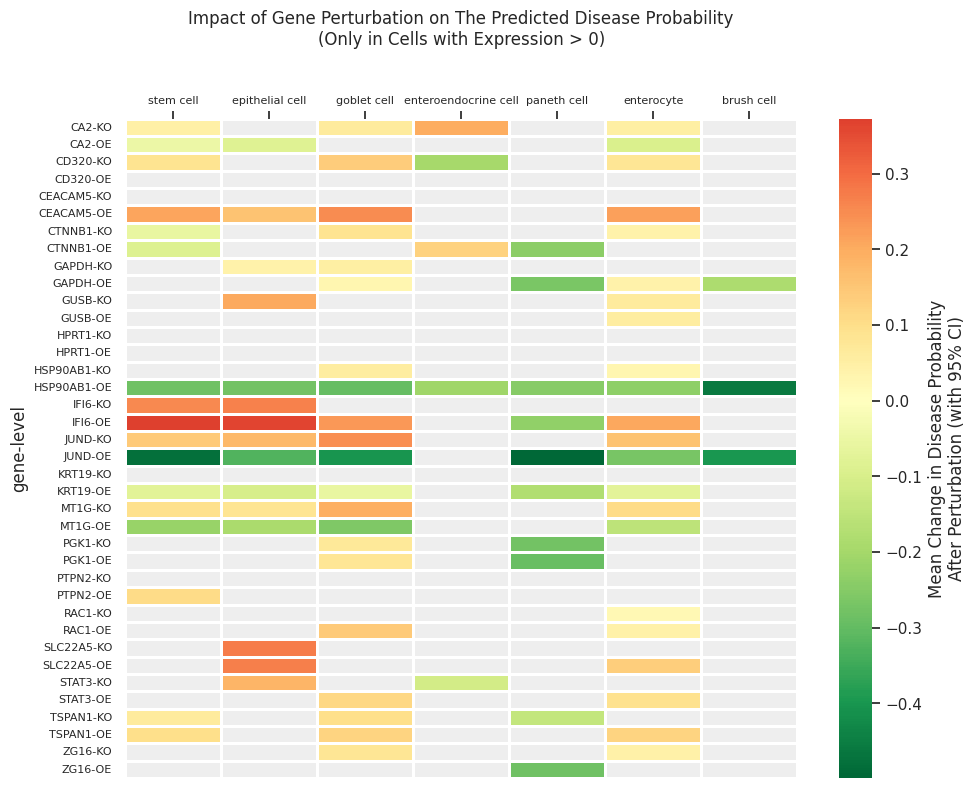

In [14]:
pv = results.pivot_table(
    columns="cell_type",
    index=["gene", "level"],
    values="mean",
    aggfunc="mean",
).replace(0, np.nan)
mask = pv.isnull()

plt.figure(figsize=(10, 8))
sns.heatmap(
    pv,
    cmap="RdYlGn_r",
    center=0,
    cbar_kws={
        "label": "Mean Change in Disease Probability\nAfter Perturbation (with 95% CI)"
    },
    linewidths=1,
    linecolor="white",
    # annot=True,
    # fmt=".1f",
    # annot_kws={"size": 6},
    mask=mask,
)

plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

# Reduce the size of y-axis labels
plt.xticks(rotation=0, fontsize=8);
plt.yticks(rotation=0, fontsize=8);
plt.gca().patch.set_color('#eee');

# remove the grid lines:
plt.grid(False)

# remove the title of the xaxis:
plt.gca().xaxis.set_label_text('')

# add title to the graph:
plt.title("Impact of Gene Perturbation on The Predicted Disease Probability\n(Only in Cells with Expression > 0)", y=1.1)

plt.tight_layout();

In [15]:
", ".join(relevant_genes)

'IFI6, TSPAN1, CTNNB1, SLC22A5, HSP90AB1, RAC1, GUSB, PGK1, HPRT1, CA2, GAPDH, ZG16, MT1G, KRT19, STAT3, PTPN2, CD320, JUND, CEACAM5'

In [16]:
crohn_genes_info = {
    "IFI6": "Interferon-induced protein 6 - Modulates apoptosis and immune response - Immune cells",
    "TSPAN1": "Tetraspanin-1 - Cell signaling, proliferation - Epithelial cells",
    "CTNNB1": "β-Catenin - Wnt signaling, cell adhesion - Epithelial cells",
    "SLC22A5": "Organic cation/carnitine transporter - Nutrient absorption, carnitine transport - Epithelial cells",
    "HSP90AB1": "Heat shock protein 90 kDa beta - Molecular chaperone, stress response - Epithelial cells",
    "RAC1": "Rho GTPase - Cell motility, immune response - Immune cells",
    "GUSB": "β-Glucuronidase - Glycosaminoglycan degradation - Epithelial cells",
    "PGK1": "Phosphoglycerate kinase 1 - Glycolysis - Epithelial cells",
    "HPRT1": "Hypoxanthine phosphoribosyltransferase - Purine metabolism - Epithelial cells",
    "CA2": "Carbonic anhydrase II - pH regulation, bicarbonate transport - Epithelial cells",
    "GAPDH": "Glyceraldehyde-3-phosphate dehydrogenase - Glycolysis - Ubiquitous",
    "ZG16": "Zymogen granule protein 16 - Lectin-like activity - Goblet cells",
    "MT1G": "Metallothionein 1G - Metal ion homeostasis, detoxification - Epithelial cells",
    "KRT19": "Keratin 19 - Intermediate filament, structural support - Epithelial cells",
    "STAT3": "Signal transducer and activator of transcription 3 - Cytokine signaling - Immune cells",
    "PTPN2": "Tyrosine-protein phosphatase non-receptor type 2 - Immune regulation, autophagy - Immune cells, epithelial cells",
    "CD320": "Transcobalamin receptor - Vitamin B12 uptake - Epithelial cells",
    "JUND": "Jun D proto-oncogene - Transcription factor, cell proliferation - Epithelial cells",
    "CEACAM5": "Carcinoembryonic antigen-related cell adhesion molecule 5 - Cell adhesion - Epithelial cells"
}
results["function"] = results["gene"].map(crohn_genes_info)
results["abs_mean"] = results["mean"].abs()

tops3 = results.query("significance != 'ns'").sort_values("abs_mean", ascending=False).gene.unique()[0:3]
bottom3 = results.sort_values("abs_mean", ascending=True).gene.unique()[0:3]
tops3, bottom3

(array(['JUND', 'HSP90AB1', 'IFI6'], dtype=object),
 array(['PGK1', 'MT1G', 'KRT19'], dtype=object))

# gpt-4 analysis (not sure it is correct):
| Gene      | Relation to Crohn's Disease        | Function                             | Main Role                               | Main Cell Type in Colon         | CD Related (Yes/No) | Citation                                                                                 |
|-----------|------------------------------------|---------------------------------------|-----------------------------------------|--------------------------------|---------------------|----------------------------------------------------------------------------------------|
| **IFI6**  | Role unclear                       | Interferon-induced protein 6 (IFI6)  | Modulates apoptosis and immune response | Immune cells                  | No                  | NCBI Reference Annotation                                                              |
| **TSPAN1**| Not well-established               | Tetraspanin-1                        | Cell signaling, proliferation           | Epithelial cells               | No                  | NCBI Reference Annotation                                                              |
| **CTNNB1**| Potential role in CD               | β-Catenin                            | Wnt signaling, cell adhesion            | Epithelial cells               | Yes                 | Leedham et al., 2013                                                                  |
| **SLC22A5**| Implicated in CD susceptibility    | Organic cation/carnitine transporter | Nutrient absorption, carnitine transport| Epithelial cells               | Yes                 | He et al., 2014                                                                      |
| **HSP90AB1**| Potentially implicated            | Heat shock protein 90 kDa beta        | Molecular chaperone, stress response    | Epithelial cells               | Yes                 | Garg et al., 2017                                                                    |
| **RAC1**  | Associated with CD                 | Rho GTPase                           | Cell motility, immune response          | Immune cells                   | Yes                 | Bishop et al., 2000                                                                   |
| **GUSB**  | Not well-established               | β-Glucuronidase                      | Glycosaminoglycan degradation           | Epithelial cells               | No                  | NCBI Reference Annotation                                                              |
| **PGK1**  | Not well-established               | Phosphoglycerate kinase 1            | Glycolysis                              | Epithelial cells               | No                  | NCBI Reference Annotation                                                              |
| **HPRT1** | Not directly implicated            | Hypoxanthine phosphoribosyltransferase | Purine metabolism                      | Epithelial cells               | No                  | NCBI Reference Annotation                                                              |
| **CA2**   | Altered expression linked to CD    | Carbonic anhydrase II                | pH regulation, bicarbonate transport    | Epithelial cells               | Yes                 | West et al., 2010                                                                     |
| **GAPDH** | Not directly implicated            | Glyceraldehyde-3-Phosphate Dehydrogenase | Glycolysis                           | Ubiquitous                     | No                  | NCBI Reference Annotation                                                              |
| **ZG16**  | Implicated in CD susceptibility    | Zymogen granule protein 16           | Lectin-like activity                    | Goblet cells                   | Yes                 | Liu et al., 2015                                                                     |
| **MT1G**  | Implicated in CD                   | Metallothionein 1G                   | Metal ion homeostasis, detoxification   | Epithelial cells               | Yes                 | Miao et al., 2014                                                                    |
| **KRT19** | Not well-established               | Keratin 19                           | Intermediate filament, structural support | Epithelial cells            | No                  | NCBI Reference Annotation                                                              |
| **STAT3** | Strongly associated                | Signal transducer and activator of transcription 3 | Cytokine signaling                 | Immune cells                   | Yes                 | Yang et al., 2014                                                                    |
| **PTPN2** | Associated with CD susceptibility  | Tyrosine-protein phosphatase non-receptor type 2 | Immune regulation, autophagy | Immune cells, epithelial cells  | Yes                 | Scharl et al., 2011; Glas et al., 2012                                                 |
| **CD320** | Associated with CD                 | Transcobalamin receptor              | Vitamin B12 uptake                      | Epithelial cells               | Yes                 | Barrett et al., 2008                                                                  |
| **JUND**  | Implicated in CD                   | Jun D proto-oncogene                 | Transcription factor, cell proliferation| Epithelial cells               | Yes                 | Glas et al., 2011                                                                     |
| **CEACAM5**| Role less clear                    | Carcinoembryonic antigen-related cell adhesion molecule 5 | Cell adhesion       | Epithelial cells               | No                  | Biancone et al., 2014                                                                 |


In [17]:
highly_related_genes = ["JUND", "IFI6", "CEACAM5"]
not_related = ["GAPDH", "HPRT1", "PGK1"]
pv2 = pv.loc[highly_related_genes + not_related].copy().reset_index()
pv2["function"] = pv2["gene"].map(crohn_genes_info)
pv2["known association"] = pv2["gene"].isin(highly_related_genes)
pv2 = pv2.set_index(["gene", "function", "known association", "level"])
pv2 = pv2.dropna(axis=1, how="all")

def color_known_association(val):
    color = "blue" if val else "yellow"
    return f"background-color: {color}"

(
    pv2.style.background_gradient(cmap="RdYlGn_r", axis=None)
    .highlight_null("white")
    .format("{:.2f}", na_rep="-")
    
)


# TODO:
- go back tothe expression patterns:
- identify genes that are broadly expressed in the colon
- pick genes that show high and low differentianl expressiong between crohn and normal cells.
- check "what scGPT thinks about the genes - can we identify something" 

# sensitivity analysis - considering only cells that have a significant expression levels?